In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import math
from sklearn.preprocessing import MinMaxScaler

In [39]:
DIR = '../data/'

In [2]:
# read the json file domain1_train.json in to the system
domain1 = pd.read_json('data/domain1_train.json', lines=True)

# read the json file domain2_train.json in to the system
domain2 = pd.read_json('data/domain2_train.json', lines=True)

# read test_set.json into the system
test = pd.read_json('data/test_set.json', lines=True)

In [41]:
# Grouping data for Domain 1
dm1_machine, dm1_human = domain1[domain1['label'] == 0], domain1[domain1['label'] == 1]

# Grouping data for Domain 2
dm2_machine, dm2_human = domain2[domain2['label'] == 0], domain2[domain2['label'] == 1]

In [3]:
# repeat the human label for multiple times

def replicate(df, multiplication):
    
    # rows with label 1
    label_1_rows = df[df['label'] == 1]
    # Replicate the rows
    replicated_df = pd.concat([label_1_rows] * (multiplication-1), ignore_index=True)
    # Concatenate the original dataframe and the replicated dataframe
    result_df = pd.concat([df, replicated_df], ignore_index=True)
    
    return result_df

In [4]:
# random sample with replacement from label 1
# label_1_rate: the rate of label 1 in the sampled dataframe, should be between 0 and 1

def rated_sample(df, label_1_rate):

    sampled_label_0 = df[df['label'] == 0]
    label_0_count = len(df[df['label'] == 0])

    #calculate the number of label 1 samples
    sampled_label_1_count = int(label_1_rate * label_0_count)
    
    # random sample with replacement from label 1
    sampled_label_1 = df[df['label'] == 1].sample(n=sampled_label_1_count, replace=True)

    # concatenate the sampled label 0 and sampled label 1
    sampled_df = pd.concat([sampled_label_0, sampled_label_1])
    
    return sampled_df

In [5]:
# random sample without replacement from label 0
# label_0_rate: the rate of label 0 in the sampled dataframe, can be any number

def under_sample(df, label_0_rate):

    sampled_label_1 = df[df['label'] == 1]
    label_1_count = len(df[df['label'] == 1])

    #calculate the number of label 0 samples
    sampled_label_0_count = int(label_0_rate * label_1_count)

    total_label_0 = df[df['label'] == 0]

    # calculate the number needed for each model
    model_count = sampled_label_0_count // 7
    sampled_label_0 = pd.DataFrame()

    # use for loop to sample from each model
    for i in range(7):
        model = total_label_0[total_label_0['model'] == i]
        sampled_model = model.sample(n=model_count, replace=False)
        sampled_label_0 = pd.concat([sampled_label_0, sampled_model])

    # concatenate the sampled label 0 and sampled label 1
    sampled_df = pd.concat([sampled_label_1, sampled_label_0])
    
    return sampled_df

In [44]:
## Bootstrap human instances in domain2
# %run explore.ipynb
newdomain2 = rated_sample(domain2,1)
newdomain2 = newdomain2.sort_index()
newdomain2.label.value_counts(dropna=False)

1    12750
0    12750
Name: label, dtype: int64

train test split

In [45]:
# split data for validation
# train_domain1, valid_domain1 = train_test_split(domain1,test_size=0.2,random_state=7)
# train_domain2, valid_domain2 = train_test_split(newdomain2,test_size=0.2,random_state=7) 

In [130]:
# pip install joblib


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from joblib import dump, load

## First attempt: Bag of word, with no additional feature

### 1. only use Domain 2 to train the model

#### **1.1 baseline attempt, no balancing the data**

In [9]:
svm_dm2 = load('C:/Users/dell/Desktop/svm_models/svm_dm2.joblib')
svm_dm2_vectorizer = load('C:/Users/dell/Desktop/svm_models/svm_dm2_vectorizer.joblib')

train test split

In [46]:
train_dm2, valid_dm2 = train_test_split(domain2,test_size=0.2,random_state=7) 

In [47]:
print('training set size {}'.format(train_dm2.shape))
print('test set size {}' .format(valid_dm2.shape))

training set size (11920, 3)
test set size (2980, 3)


produce bag of word on train_dm2

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

In [144]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in train_dm2['text']]

# learn the token dictionary and return document-term matrix
train_dm2_vec = vectorizer.fit_transform(corpus)

# get column names in domain1
train_dm2_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
train_dm2_Xs = train_dm2_vec.toarray()

train_dm2_Xs.shape

(11920, 4940)

produce bag of word on valid_dm2

In [147]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_dm2['text']]

# learn the token dictionary and return document-term matrix
valid_dm2_vec = vectorizer.transform(corpus)

# get column names in domain1
valid_dm2_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
valid_dm2_Xs = valid_dm2_vec.toarray()

valid_dm2_Xs.shape

(2980, 4940)

In [51]:
from sklearn.svm import SVC
svm_dm2 = SVC()

In [52]:
svm_dm2.fit(train_dm2_Xs, train_dm2['label'])

valid_dm2_Xs_pred = svm_dm2.predict(valid_dm2_Xs)

In [53]:
train_score = svm_dm2.score(train_dm2_Xs, train_dm2['label'])
valid_score = svm_dm2.score(valid_dm2_Xs, valid_dm2['label'])

print("SVM domain1 training score: {}".format(train_score))
print("SVM domain1 valid score: {}".format(valid_score))

SVM domain1 training score: 0.875755033557047
SVM domain1 valid score: 0.864765100671141


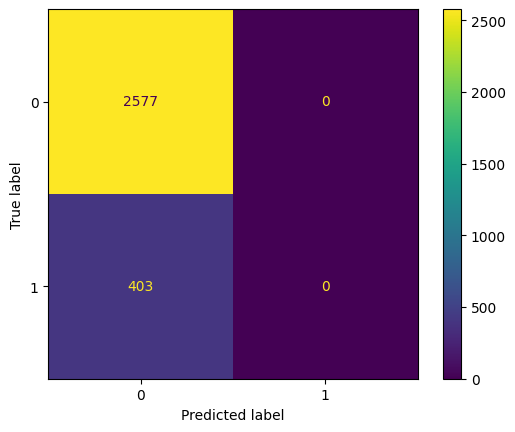

In [54]:
from sklearn import metrics
cm_dm2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_dm2['label'], valid_dm2_Xs_pred), display_labels=svm_dm2.classes_)
cm_dm2.plot()

In [55]:
print(classification_report(valid_dm2['label'], valid_dm2_Xs_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2577
           1       0.00      0.00      0.00       403

    accuracy                           0.86      2980
   macro avg       0.43      0.50      0.46      2980
weighted avg       0.75      0.86      0.80      2980



c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [56]:
print(f1_score(valid_dm2['label'], valid_dm2_Xs_pred, average='macro'))

0.46373942774878535


In [145]:
dump(svm_dm2, 'svm_models/svm_dm2.joblib')
dump(vectorizer, 'svm_models/svm_dm2_vectorizer.joblib')

['svm_models/svm_dm2_vectorizer.joblib']

#### **1.2 try to solve the imbalance problem by rated_sample to 1:1**

In [11]:
svm_newdm2 = load('C:/Users/dell/Desktop/svm_models/svm_newdm2.joblib')
svm_newdm2_vectorizer = load('C:/Users/dell/Desktop/svm_models/svm_newdm2_vectorizer.joblib')

balance data by self-defined bootstrap method

In [80]:
newdomain2 = rated_sample(domain2,0.5)
newdomain2 = newdomain2.sort_index()
newdomain2.label.value_counts(dropna=False)

1    12750
0    12750
Name: label, dtype: int64

train test split

In [95]:
train_newdm2, valid_newdm2 = train_test_split(newdomain2,test_size=0.2,random_state=7) 

In [97]:
valid_newdm2.head(10)

,text,label,model
1758,"[397, 5, 146, 2, 106, 0, 40, 2300, 3739, 4258,...",1,NaN
7808,"[2744, 0, 7, 756, 4, 0, 1595, 22, 0, 1, 451, 2...",0,1.0
789,"[10, 2157, 1, 21, 424, 3125, 958, 65, 54, 1, 5...",1,NaN
729,"[11, 147, 9, 5, 464, 0, 392, 12, 0, 4894, 1, 4...",1,NaN
13380,"[0, 3053, 0, 0, 10, 1133, 385, 6, 0, 4, 0, 226...",0,3.0
14503,"[2, 4807, 3224, 1, 13, 8, 15, 467, 6, 163, 471...",0,6.0
1317,"[0, 5, 1984, 3907, 3, 7, 0, 13, 1, 42, 64, 391...",1,NaN
409,"[0, 2088, 1528, 100, 0, 22, 14, 0, 4, 0, 2, 10...",1,NaN
8512,"[304, 57, 2, 253, 386, 79, 0, 0, 1, 13, 914, 6...",0,0.0
1525,"[5, 0, 0, 2034, 867, 4, 375, 19, 5, 0, 1245, 1...",1,NaN


In [96]:
print('training set size {}'.format(train_newdm2.shape))
print('test set size {}' .format(valid_newdm2.shape))

training set size (20400, 3)
test set size (5100, 3)


produce bag of word on train_dm2

In [83]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

In [152]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in train_newdm2['text']]

# learn the token dictionary and return document-term matrix
train_newdm2_vec = vectorizer.fit_transform(corpus)

# get column names in domain1
train_newdm2_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
train_newdm2_Xs = train_newdm2_vec.toarray()

train_newdm2_Xs.shape

(20400, 4942)

produce bag of word on valid_dm2

In [156]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_newdm2['text']]

# learn the token dictionary and return document-term matrix
valid_newdm2_vec = vectorizer.transform(corpus)

# get column names in domain1
valid_newdm2_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
valid_newdm2_Xs = valid_newdm2_vec.toarray()

valid_newdm2_Xs.shape

(5100, 4942)

In [86]:
from sklearn.svm import SVC
svm_newdm2 = SVC()

In [ ]:
svm_newdm2.fit(train_newdm2_Xs, train_newdm2['label'])

valid_newdm2_Xs_pred = svm_newdm2.predict(valid_newdm2_Xs)

In [110]:
train_score = svm_newdm2.score(train_newdm2_Xs, train_newdm2['label'])
valid_score = svm_newdm2.score(valid_newdm2_Xs, valid_newdm2['label'])

print("SVM domain2 training score: {}".format(train_score))
print("SVM domain2 valid score: {}".format(valid_score))

SVM domain1 training score: 0.8692647058823529
SVM domain1 valid score: 0.8249019607843138


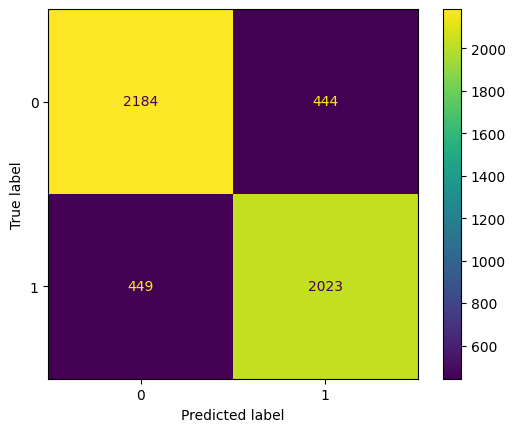

In [107]:
from sklearn import metrics
cm_dm2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_newdm2['label'], valid_newdm2_Xs_pred), display_labels=svm_newdm2.classes_)
cm_dm2.plot()

In [108]:
print(classification_report(valid_newdm2['label'], valid_newdm2_Xs_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2628
           1       0.82      0.82      0.82      2472

    accuracy                           0.82      5100
   macro avg       0.82      0.82      0.82      5100
weighted avg       0.82      0.82      0.82      5100



In [109]:
print(f1_score(valid_newdm2['label'], valid_newdm2_Xs_pred, average='macro'))

0.8247272878134337


In [153]:
dump(svm_newdm2, 'svm_models/svm_newdm2.joblib')
dump(vectorizer, 'svm_models/svm_newdm2_vectorizer.joblib')

['svm_models/svm_newdm2_vectorizer.joblib']

#### **1.3 try to solve the imbalance problem by under_sample to 1:1**

In [7]:
svm_underdm2 = load('C:/Users/dell/Desktop/svm_models/svm_underdm2.joblib')
svm_underdm2_vectorizer = load('C:/Users/dell/Desktop/svm_models/svm_underdm2_vectorizer.joblib')

In [8]:
under_dm2 = under_sample(domain2,1)
under_dm2 = under_dm2.sort_index()
under_dm2.label.value_counts(dropna=False)

1    2150
0    2149
Name: label, dtype: int64

train test split

In [13]:
train_underdm2, valid_underdm2 = train_test_split(under_dm2,test_size=0.2,random_state=7) 

In [14]:
valid_underdm2.head(10)

,text,label,model
11715,"[26, 75, 1707, 5, 1182, 8, 15, 2429, 1, 14, 10...",0,6.0
3091,"[10, 694, 16, 21, 948, 4348, 940, 1, 14, 10, 6...",0,6.0
1470,"[175, 0, 0, 24, 2, 0, 299, 6, 2, 106, 0, 3397,...",1,NaN
652,"[16, 120, 0, 2173, 3406, 11, 171, 39, 316, 18,...",1,NaN
5770,"[349, 791, 17, 4, 3431, 54, 5, 900, 205, 6, 82...",0,0.0
638,"[2, 659, 106, 17, 9, 5, 69, 0, 1, 2, 170, 88, ...",1,NaN
325,"[63, 2, 3190, 2365, 62, 166, 299, 1099, 385, 1...",1,NaN
10658,"[42, 133, 4, 5, 1576, 7, 250, 45, 191, 1, 2, 2...",0,1.0
10989,"[2, 1826, 606, 1467, 64, 31, 1038, 1, 2, 663, ...",0,0.0
3228,"[10, 443, 7, 158, 2542, 6, 0, 16, 36, 922, 317...",0,5.0


In [15]:
print('training set size {}'.format(train_underdm2.shape))
print('test set size {}' .format(valid_underdm2.shape))

training set size (3439, 3)
test set size (860, 3)


produce bag of word on train_dm2

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
svm_underdm2_vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

In [19]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in train_underdm2['text']]

# learn the token dictionary and return document-term matrix
train_underdm2_vec = svm_underdm2_vectorizer.fit_transform(corpus)

# get data in domain1
train_underdm2_Xs = train_underdm2_vec.toarray()

train_underdm2_Xs.shape

(3439, 4904)

produce bag of word on valid_dm2

In [20]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_underdm2['text']]

# learn the token dictionary and return document-term matrix
valid_underdm2_vec = svm_underdm2_vectorizer.transform(corpus)

# get data in domain1
valid_underdm2_Xs = valid_underdm2_vec.toarray()

valid_underdm2_Xs.shape

(860, 4904)

In [21]:
from sklearn.svm import SVC
svm_underdm2 = SVC()

In [22]:
svm_underdm2.fit(train_underdm2_Xs, train_underdm2['label'])

valid_underdm2_Xs_pred = svm_underdm2.predict(valid_underdm2_Xs)

In [23]:
train_score = svm_underdm2.score(train_underdm2_Xs, train_underdm2['label'])
valid_score = svm_underdm2.score(valid_underdm2_Xs, valid_underdm2['label'])

print("SVM domain2 training score: {}".format(train_score))
print("SVM domain2 valid score: {}".format(valid_score))

SVM domain2 training score: 0.7705728409421343
SVM domain2 valid score: 0.6465116279069767


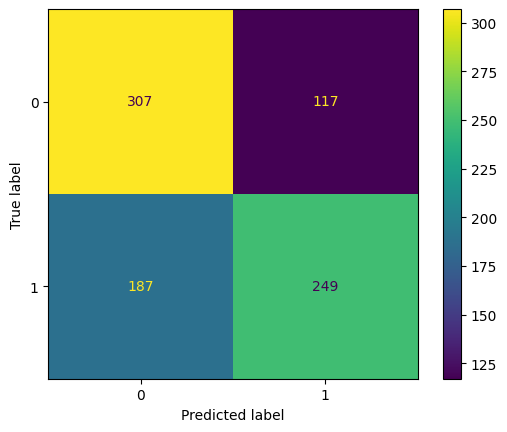

In [24]:
from sklearn import metrics
cm_dm2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_underdm2['label'], valid_underdm2_Xs_pred), display_labels=svm_underdm2.classes_)
cm_dm2.plot()

In [25]:
print(classification_report(valid_underdm2['label'], valid_underdm2_Xs_pred))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67       424
           1       0.68      0.57      0.62       436

    accuracy                           0.65       860
   macro avg       0.65      0.65      0.64       860
weighted avg       0.65      0.65      0.64       860



In [27]:
print(f1_score(valid_underdm2['label'], valid_underdm2_Xs_pred, average='macro'))

0.6448964734134164


In [28]:
dump(svm_underdm2, 'C:/Users/dell/Desktop/svm_models/svm_underdm2.joblib')
dump(svm_underdm2_vectorizer, 'C:/Users/dell/Desktop/svm_models/svm_underdm2_vectorizer.joblib')

['C:/Users/dell/Desktop/svm_models/svm_underdm2_vectorizer.joblib']

use domain 1 data as validation

In [9]:
# use domain 1 data as the validation set, test the svm_underdm2 accuracy

# use valid_dm1 as the validation set, test the svm_underdm2 accuracy
train_dm1, valid_dm1 = train_test_split(domain1,test_size=0.2,random_state=7) 

# predict the label for valid_dm1

# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_dm1['text']]
# learn the token dictionary and return document-term matrix
valid_dm1_vec = svm_underdm2_vectorizer.transform(corpus)
# get data in domain1
valid_dm1_Xs = valid_dm1_vec.toarray()

valid_dm1_pred = svm_underdm2.predict(valid_dm1_Xs)

# calculate the accuracy
valid_dm1_score = svm_underdm2.score(valid_dm1_Xs, valid_dm1['label'])
print("SVM domain1 valid score: {}".format(valid_dm1_score))
# calculate the f1 score
print(f1_score(valid_dm1['label'], valid_dm1_pred, average='macro'))


SVM domain1 valid score: 0.4658974358974359
0.3287214141397281


use domain fusion as validation

In [10]:
domain1_mod = domain1.copy()
domain1_mod["model"] = 7
under_balance_dm = pd.concat([domain1_mod, under_dm2], ignore_index=True)
# under_balance_dm.shape

train_under_balance_dm, valid_under_balance_dm = train_test_split(under_balance_dm,test_size=0.2,random_state=7) 

# predict the label for valid_under_balance_dm

# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_under_balance_dm['text']]
# learn the token dictionary and return document-term matrix
valid_under_balance_dm_vec = svm_underdm2_vectorizer.transform(corpus)
# get data in domain
valid_under_balance_dm_Xs = valid_under_balance_dm_vec.toarray()

valid_under_balance_dm_pred = svm_underdm2.predict(valid_under_balance_dm_Xs)

# calculate the accuracy
valid_under_balance_dm_score = svm_underdm2.score(valid_under_balance_dm_Xs, valid_under_balance_dm['label'])
print("SVM domain1 valid score: {}".format(valid_under_balance_dm_score))
# calculate the f1 score
print(f1_score(valid_under_balance_dm['label'], valid_under_balance_dm_pred, average='macro'))

SVM domain1 valid score: 0.5172268907563026
0.42867242837095115


### 2. only use Domain 1 to train the model

In [11]:
svm_dm1 = load('C:/Users/dell/Desktop/svm_models/svm_dm1.joblib')
svm_dm1_vectorizer = load('C:/Users/dell/Desktop/svm_models/svm_dm1_vectorizer.joblib')

train test split

In [12]:
train_dm1, valid_dm1 = train_test_split(domain1,test_size=0.2,random_state=7) 

In [58]:
print('training set size {}'.format(train_dm1.shape))
print('test set size {}' .format(valid_dm1.shape))

training set size (15600, 2)
test set size (3900, 2)


produce bag of word on train_dm1

In [140]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in train_dm1['text']]

# learn the token dictionary and return document-term matrix
train_dm1_vec = vectorizer.fit_transform(corpus)

# get column names in domain1
train_dm1_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
train_dm1_Xs = train_dm1_vec.toarray()

train_dm1_Xs.shape

(15600, 4900)

produce bag of word on valid_dm1

In [158]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_dm1['text']]

# learn the token dictionary and return document-term matrix
valid_dm1_vec = vectorizer.transform(corpus)

# get column names in domain1
valid_dm1_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
valid_dm1_Xs = valid_dm1_vec.toarray()

valid_dm1_Xs.shape

(3900, 4900)

In [61]:
from sklearn.svm import SVC
svm_dm1 = SVC()

In [62]:
svm_dm1.fit(train_dm1_Xs, train_dm1['label'])

valid_dm1_Xs_pred = svm_dm1.predict(valid_dm1_Xs)

In [63]:
train_score = svm_dm1.score(train_dm1_Xs, train_dm1['label'])
valid_score = svm_dm1.score(valid_dm1_Xs, valid_dm1['label'])

print("SVM domain1 training score: {}".format(train_score))
print("SVM domain1 valid score: {}".format(valid_score))

SVM domain1 training score: 0.955448717948718
SVM domain1 valid score: 0.9164102564102564


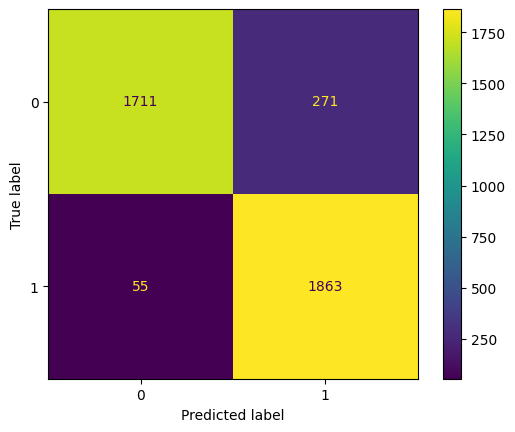

In [90]:
from sklearn import metrics
cm_dm1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_dm1['label'], valid_dm1_Xs_pred), display_labels=svm_dm1.classes_)
cm_dm1.plot()

In [65]:
print(classification_report(valid_dm1['label'], valid_dm1_Xs_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1982
           1       0.87      0.97      0.92      1918

    accuracy                           0.92      3900
   macro avg       0.92      0.92      0.92      3900
weighted avg       0.92      0.92      0.92      3900



In [66]:
print(f1_score(valid_dm1['label'], valid_dm1_Xs_pred, average='macro'))

0.916283090369487


In [141]:
dump(svm_dm1, 'svm_models/svm_dm1.joblib')
dump(vectorizer, 'svm_models/svm_dm1_vectorizer.joblib')

['svm_models/svm_dm1_vectorizer.joblib']

use domain 2 data as validation

In [17]:
# use valid_underdm2 as the validation set, test the svm_dm1 accuracy
train_underdm2, valid_underdm2 = train_test_split(under_dm2,test_size=0.2,random_state=7)

# predict the label for valid_underdm2

# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_underdm2['text']]
# learn the token dictionary and return document-term matrix
valid_underdm2_vec = svm_dm1_vectorizer.transform(corpus)
# get data in domain
valid_underdm2_Xs = valid_underdm2_vec.toarray()

valid_underdm2_pred = svm_dm1.predict(valid_underdm2_Xs)

# calculate the accuracy
valid_underdm2_score = svm_dm1.score(valid_underdm2_Xs, valid_underdm2['label'])
print("SVM domain1 valid score: {}".format(valid_underdm2_score))
# calculate the f1 score
print(f1_score(valid_underdm2['label'], valid_underdm2_pred, average='macro'))

SVM domain1 valid score: 0.48372093023255813
0.46472728903941374


use domain fusion as validation

In [18]:
# use valid_under_balance_dm as the validation set, test the svm_dm1 accuracy
train_under_balance_dm, valid_under_balance_dm = train_test_split(under_balance_dm,test_size=0.2,random_state=7)

# predict the label for valid_under_balance_dm

# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_under_balance_dm['text']]
# learn the token dictionary and return document-term matrix
valid_under_balance_dm_vec = svm_dm1_vectorizer.transform(corpus)
# get data in domain
valid_under_balance_dm_Xs = valid_under_balance_dm_vec.toarray()

valid_under_balance_dm_pred = svm_dm1.predict(valid_under_balance_dm_Xs)

# calculate the accuracy
valid_under_balance_dm_score = svm_dm1.score(valid_under_balance_dm_Xs, valid_under_balance_dm['label'])
print("SVM domain1 valid score: {}".format(valid_under_balance_dm_score))
# calculate the f1 score
print(f1_score(valid_under_balance_dm['label'], valid_under_balance_dm_pred, average='macro'))

SVM domain1 valid score: 0.8533613445378151
0.8530643552367604


### 3. Combine Domain 1 and Domain 2 to train the model

#### **3.1 Simply combine Domain 1 and Domain 2**

In [159]:
svm_dm_merge = load('svm_models/svm_dm_merge.joblib')
svm_dm_merge_vectorizer = load('svm_models/svm_dm_merge_vectorizer.joblib')

In [67]:
domain1_mod = domain1.copy()
domain1_mod["model"] = 7
merge_dm = pd.concat([domain1_mod, domain2], ignore_index=True)

train test split

In [68]:
train_merge_dm, valid_merge_dm = train_test_split(merge_dm,test_size=0.2,random_state=7) 

In [69]:
print('training set size {}'.format(train_merge_dm.shape))
print('test set size {}' .format(valid_merge_dm.shape))

training set size (27520, 3)
test set size (6880, 3)


produce bag of word on train_merge_dm

In [136]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in train_merge_dm['text']]

# learn the token dictionary and return document-term matrix
train_merge_vec = vectorizer.fit_transform(corpus)

# get column names in domain1
train_merge_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
train_merge_Xs = train_merge_vec.toarray()

train_merge_Xs.shape

(27520, 4989)

produce bag of word on valid_merge_dm

In [160]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_merge_dm['text']]

# learn the token dictionary and return document-term matrix
valid_merge_vec = vectorizer.transform(corpus)

# get column names in domain1
valid_merge1_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
valid_merge_Xs = valid_merge_vec.toarray()

valid_merge_Xs.shape

(6880, 4989)

In [72]:
from sklearn.svm import SVC
svm_dm_merge = SVC()

In [73]:
svm_dm_merge.fit(train_merge_Xs, train_merge_dm['label'])

valid_merge_pred = svm_dm_merge.predict(valid_merge_Xs)

In [74]:
train_score = svm_dm_merge.score(train_merge_Xs, train_merge_dm['label'])
valid_score = svm_dm_merge.score(valid_merge_Xs, valid_merge_dm['label'])

print("SVM domain1 training score: {}".format(train_score))
print("SVM domain1 valid score: {}".format(valid_score))

SVM domain1 training score: 0.8985101744186047
SVM domain1 valid score: 0.8652616279069767


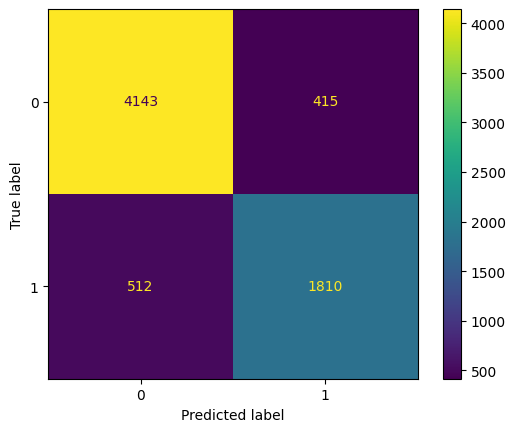

In [75]:
from sklearn import metrics
cm_dm1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_merge_dm['label'], valid_merge_pred), display_labels=svm_dm_merge.classes_)
cm_dm1.plot()

In [76]:
print(classification_report(valid_merge_dm['label'], valid_merge_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4558
           1       0.81      0.78      0.80      2322

    accuracy                           0.87      6880
   macro avg       0.85      0.84      0.85      6880
weighted avg       0.86      0.87      0.86      6880



In [77]:
print(f1_score(valid_merge_dm['label'], valid_merge_pred, average='macro'))

0.8477553125262061


In [138]:
dump(svm_dm_merge, 'svm_models/svm_dm_merge.joblib')
dump(vectorizer, 'svm_models/svm_dm_merge_vectorizer.joblib')

['svm_models/svm_dm_merge_vectorizer.joblib']

#### **3.2 Combine Domain 1 and self balanced Domain 2**

In [30]:
svm_dm_balance = load('C:/Users/dell/Desktop/svm_models/svm_dm_balance.joblib')
svm_dm_balance_vectorizer = load('C:/Users/dell/Desktop/svm_models/svm_dm_balance_vectorizer.joblib')

In [111]:
# domain1_mod = domain1.copy()
# domain1_mod["model"] = 7
balance_dm = pd.concat([domain1_mod, newdomain2], ignore_index=True)
balance_dm.shape

(45000, 3)

train test split

In [112]:
train_balance_dm, valid_balance_dm = train_test_split(balance_dm,test_size=0.2,random_state=7) 

In [113]:
print('training set size {}'.format(train_balance_dm.shape))
print('test set size {}' .format(valid_balance_dm.shape))

training set size (36000, 3)
test set size (9000, 3)


produce bag of word on train_merge_dm

In [114]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in train_balance_dm['text']]

# learn the token dictionary and return document-term matrix
train_balance_vec = vectorizer.fit_transform(corpus)

# get column names in domain1
train_balance_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
train_balance_Xs = train_balance_vec.toarray()

train_balance_Xs.shape

(36000, 4989)

produce bag of word on valid_merge_dm

In [162]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_balance_dm['text']]

# learn the token dictionary and return document-term matrix
valid_balance_vec = vectorizer.transform(corpus)

# get column names in domain1
valid_balance_vec_col = vectorizer.get_feature_names_out()

# get data in domain1
valid_balance_Xs = valid_balance_vec.toarray()

valid_balance_Xs.shape

(9000, 4989)

In [116]:
from sklearn.svm import SVC
svm_dm_balance = SVC()

In [117]:
svm_dm_balance.fit(train_balance_Xs, train_balance_dm['label'])

valid_balance_pred = svm_dm_balance.predict(valid_balance_Xs)

In [133]:
dump(svm_dm_balance, 'svm_models/svm_dm_balance.joblib')
dump(vectorizer, 'svm_models/svm_dm_balance_vectorizer.joblib')

['svm_models/svm_dm_balance_vectorizer.joblib']

In [ ]:
train_score = svm_dm_balance.score(train_balance_Xs, train_balance_dm['label'])
valid_score = svm_dm_balance.score(valid_balance_Xs, valid_balance_dm['label'])

print("SVM training score: {}".format(train_score))
print("SVM valid score: {}".format(valid_score))

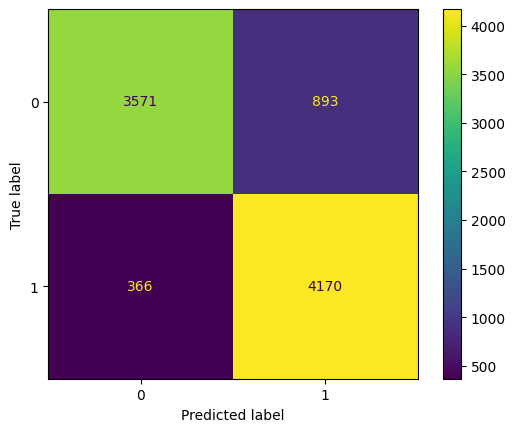

In [118]:
from sklearn import metrics
cm_dm1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_balance_dm['label'], valid_balance_pred), display_labels=svm_dm_balance.classes_)
cm_dm1.plot()

In [119]:
print(classification_report(valid_balance_dm['label'], valid_balance_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4464
           1       0.82      0.92      0.87      4536

    accuracy                           0.86      9000
   macro avg       0.87      0.86      0.86      9000
weighted avg       0.86      0.86      0.86      9000



In [120]:
print(f1_score(valid_balance_dm['label'], valid_balance_pred, average='macro'))

0.8594886963424242


<span style="color:red;">**predict test set using svm_dm_balance**</span>

In [190]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in test['text']]

# learn the token dictionary and return document-term matrix
test_vec = svm_dm_balance_vectorizer.transform(corpus)

# get column names in domain1
test_vec_col = svm_dm_balance_vectorizer.get_feature_names_out()

# get data in domain1
test_X = test_vec.toarray()

test_X.shape

(1000, 4989)

In [122]:
test_dm_balance_pred = svm_dm_balance.predict(test_X)

In [126]:
test_dm_balance_pred

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [127]:
df = pd.DataFrame({'id': range(len(test_dm_balance_pred)), 'class': test_dm_balance_pred})

In [128]:
df

,id,class
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
995,995,0
996,996,1
997,997,1
998,998,1


In [129]:
df.to_csv('data/output_test_pred_svm_dm_balance.csv', index=False)

#### **3.3 Combine dm1 and under sampled dm2**

In [ ]:
svm_dm_under_balance = load('C:/Users/dell/Desktop/svm_models/svm_dm_under_balance.joblib')
svm_dm_under_balance_vectorizer = load('C:/Users/dell/Desktop/svm_models/svm_dm_under_balance_vectorizer.joblib')

In [32]:
domain1_mod = domain1.copy()
domain1_mod["model"] = 7
under_balance_dm = pd.concat([domain1_mod, under_dm2], ignore_index=True)
under_balance_dm.shape

(23799, 3)

train test split

In [33]:
train_under_balance_dm, valid_under_balance_dm = train_test_split(under_balance_dm,test_size=0.2,random_state=7) 

In [34]:
print('training set size {}'.format(train_under_balance_dm.shape))
print('test set size {}' .format(valid_under_balance_dm.shape))

training set size (19039, 3)
test set size (4760, 3)


produce bag of word on train_merge_dm

In [35]:
svm_dm_under_balance_vectorizer = CountVectorizer()

# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in train_under_balance_dm['text']]

# learn the token dictionary and return document-term matrix
train_under_balance_vec = svm_dm_under_balance_vectorizer.fit_transform(corpus)

# get data in domain1
train_under_balance_Xs = train_under_balance_vec.toarray()

train_under_balance_Xs.shape

(19039, 4984)

produce bag of word on valid_merge_dm

In [36]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_under_balance_dm['text']]

# learn the token dictionary and return document-term matrix
valid_under_balance_vec = svm_dm_under_balance_vectorizer.transform(corpus)

# get data in domain1
valid_under_balance_Xs = valid_under_balance_vec.toarray()

valid_under_balance_Xs.shape

(4760, 4984)

In [37]:
from sklearn.svm import SVC
svm_dm_under_balance = SVC()

In [38]:
svm_dm_under_balance.fit(train_under_balance_Xs, train_under_balance_dm['label'])

valid_under_balance_pred = svm_dm_under_balance.predict(valid_under_balance_Xs)

In [39]:
dump(svm_dm_under_balance, 'C:/Users/dell/Desktop/svm_models/svm_dm_under_balance.joblib')
dump(svm_dm_under_balance_vectorizer, 'C:/Users/dell/Desktop/svm_models/svm_dm_under_balance_vectorizer.joblib')

['C:/Users/dell/Desktop/svm_models/svm_dm_under_balance_vectorizer.joblib']

In [76]:
train_score = svm_dm_under_balance.score(train_under_balance_Xs, train_under_balance_dm['label'])
valid_score = svm_dm_under_balance.score(valid_under_balance_Xs, valid_under_balance_dm['label'])

print("SVM training score: {}".format(train_score))
print("SVM valid score: {}".format(valid_score))

SVM training score: 0.9232627764063238
SVM valid score: 0.8567226890756302


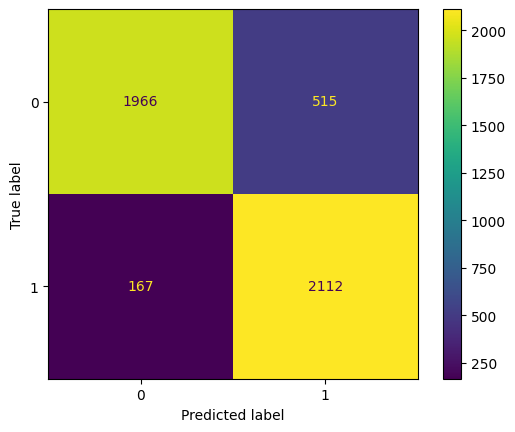

In [40]:
from sklearn import metrics
cm_dm1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_under_balance_dm['label'], valid_under_balance_pred), display_labels=svm_dm_under_balance.classes_)
cm_dm1.plot()

In [41]:
print(classification_report(valid_under_balance_dm['label'], valid_under_balance_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2481
           1       0.80      0.93      0.86      2279

    accuracy                           0.86      4760
   macro avg       0.86      0.86      0.86      4760
weighted avg       0.87      0.86      0.86      4760



In [42]:
print(f1_score(valid_under_balance_dm['label'], valid_under_balance_pred, average='macro'))

0.8565877685577721


<span style="color:red;">**predict test set using svm_dm_under_balance**</span>

In [43]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in test['text']]

# learn the token dictionary and return document-term matrix
test_vec = svm_dm_under_balance_vectorizer.transform(corpus)

# get data in domain1
test_X = test_vec.toarray()

test_X.shape

(1000, 4984)

In [44]:
test_dm_under_balance_pred = svm_dm_under_balance.predict(test_X)

In [45]:
test_dm_under_balance_pred

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [46]:
df = pd.DataFrame({'id': range(len(test_dm_under_balance_pred)), 'class': test_dm_under_balance_pred})

In [47]:
df

,id,class
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
995,995,1
996,996,1
997,997,0
998,998,1


In [48]:
df.to_csv('data/output_test_pred_svm_dm_under_balance.csv', index=False)

### <span style="color:red;">**over sampling - Stacking of three models**</span>

In [ ]:
meta_model = load('svm_meta_model_stacking.joblib')

In [163]:
balance_dm = pd.concat([domain1_mod, newdomain2], ignore_index=True)
balance_dm.shape

(45000, 3)

In [164]:
train_balance_dm, valid_balance_dm = train_test_split(balance_dm,test_size=0.2,random_state=7) 

In [165]:
print('training set size {}'.format(train_balance_dm.shape))
print('test set size {}' .format(valid_balance_dm.shape))

training set size (36000, 3)
test set size (9000, 3)


In [166]:
corpus = [' '.join(str(word_id) for word_id in document) for document in train_balance_dm['text']]

train_svm_dm1_vec = svm_dm1_vectorizer.transform(corpus)
train_svm_newdm2_vec = svm_newdm2_vectorizer.transform(corpus)
train_svm_dm_balance_vec = svm_dm_balance_vectorizer.transform(corpus)

train_svm_dm1_X = train_svm_dm1_vec.toarray()
train_svm_newdm2_X = train_svm_newdm2_vec.toarray()
train_svm_dm_balance_X = train_svm_dm_balance_vec.toarray()

(36000, 4989)

In [167]:
print(train_svm_dm1_X.shape, train_svm_newdm2_X.shape, train_svm_dm_balance_X.shape)

(36000, 4900) (36000, 4942) (36000, 4989)


In [168]:
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_balance_dm['text']]

valid_svm_dm1_vec = svm_dm1_vectorizer.transform(corpus)
valid_svm_newdm2_vec = svm_newdm2_vectorizer.transform(corpus)
valid_svm_dm_balance_vec = svm_dm_balance_vectorizer.transform(corpus)

valid_svm_dm1_X = valid_svm_dm1_vec.toarray()
valid_svm_newdm2_X = valid_svm_newdm2_vec.toarray()
valid_svm_dm_balance_X = valid_svm_dm_balance_vec.toarray()

In [169]:
print(valid_svm_dm1_X.shape, valid_svm_newdm2_X.shape, valid_svm_dm_balance_X.shape)

(9000, 4900) (9000, 4942) (9000, 4989)


In [170]:
ptrain_svm_dm1 = svm_dm1.predict(train_svm_dm1_X)
ptrain_svm_newdm2 = svm_newdm2.predict(train_svm_newdm2_X)
ptrain_svm_dm_balance = svm_dm_balance.predict(train_svm_dm_balance_X)

In [172]:
pvalid_svm_dm1 = svm_dm1.predict(valid_svm_dm1_X)
pvalid_svm_newdm2 = svm_newdm2.predict(valid_svm_newdm2_X)
pvalid_svm_dm_balance = svm_dm_balance.predict(valid_svm_dm_balance_X)

In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [173]:
X_train_meta = np.column_stack((ptrain_svm_dm1, ptrain_svm_newdm2, ptrain_svm_dm_balance))

# Train the meta-model on the combined feature matrix and the target values
meta_model = LogisticRegressionCV(cv = 20, random_state=7, max_iter=150)

meta_model.fit(X_train_meta, train_balance_dm['label'])

LogisticRegressionCV(cv=20, max_iter=150, random_state=7)

In [174]:
X_val_meta = np.column_stack((pvalid_svm_dm1,pvalid_svm_newdm2,pvalid_svm_dm_balance))

y_val_meta = meta_model.predict(X_val_meta)

In [175]:
y_val_meta = pd.DataFrame(y_val_meta, columns=['meta'])

In [176]:
pred_table = pd.DataFrame({'model1' : np.array(pvalid_svm_dm1),
                            'model2' : np.array(pvalid_svm_newdm2),
                            'model3' : np.array(pvalid_svm_dm_balance)})
pred_table.shape

(9000, 3)

In [177]:
pred_table['stacking'] = y_val_meta['meta'].apply(lambda x: 0 if x < 0.5 else 1)

In [178]:
pred_table.head()

,model1,model2,model3,stacking
0,0,1,1,1
1,1,1,1,1
2,1,0,1,1
3,0,0,0,0
4,1,0,0,0


In [180]:
print(f1_score(valid_balance_dm['label'], pred_table['stacking'], average='macro'))

0.8594886963424242


In [192]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in test['text']]

# learn the token dictionary and return document-term matrix
test_svm_dm1_vec = svm_dm1_vectorizer.transform(corpus)
test_svm_newdm2_vec = svm_newdm2_vectorizer.transform(corpus)
test_svm_dm_balance_vec = svm_dm_balance_vectorizer.transform(corpus)

test_svm_dm1_X = test_svm_dm1_vec.toarray()
test_svm_newdm2_X = test_svm_newdm2_vec.toarray()
test_svm_dm_balance_X = test_svm_dm_balance_vec.toarray()

print(test_svm_dm1_X.shape, test_svm_newdm2_X.shape, test_svm_dm_balance_X.shape)

(1000, 4900) (1000, 4942) (1000, 4989)


In [193]:
ptest_svm_dm1 = svm_dm1.predict(test_svm_dm1_X)
ptest_svm_newdm2 = svm_newdm2.predict(test_svm_newdm2_X)
ptest_svm_dm_balance = svm_dm_balance.predict(test_svm_dm_balance_X)

In [194]:
X_test_meta = np.column_stack((ptest_svm_dm1,ptest_svm_newdm2,ptest_svm_dm_balance))

y_test_meta = meta_model.predict(X_test_meta)

In [195]:
ptest_svm_dm1.shape

(1000,)

In [196]:
df = pd.DataFrame({'id': range(len(y_test_meta)), 'class': y_test_meta})
df.to_csv('data/output_test_svm_meta_modele.csv', index=False)

In [198]:
dump(meta_model, 'svm_meta_model_stacking.joblib')
# dump(vectorizer, 'svm_models/svm_dm_merge_vectorizer.joblib')

['svm_meta_model_stacking.joblib']

### <span style="color:red;">**under sampling - Stacking of three models**</span>

In [ ]:
meta_under_model = load('C:/Users/dell/Desktop/svm_meta_under_model_stacking.joblib')

In [49]:
domain1_mod = domain1.copy()
domain1_mod["model"] = 7
under_balance_dm = pd.concat([domain1_mod, under_dm2], ignore_index=True)
under_balance_dm.shape

(23799, 3)

In [50]:
train_under_balance_dm, valid_under_balance_dm = train_test_split(under_balance_dm,test_size=0.2,random_state=7) 

In [51]:
print('training set size {}'.format(train_under_balance_dm.shape))
print('test set size {}' .format(valid_under_balance_dm.shape))

training set size (19039, 3)
test set size (4760, 3)


In [52]:
corpus = [' '.join(str(word_id) for word_id in document) for document in train_under_balance_dm['text']]

train_svm_dm1_vec = svm_dm1_vectorizer.transform(corpus)
train_svm_underdm2_vec = svm_underdm2_vectorizer.transform(corpus)
train_svm_dm_under_balance_vec = svm_dm_under_balance_vectorizer.transform(corpus)

train_svm_dm1_X = train_svm_dm1_vec.toarray()
train_svm_underdm2_X = train_svm_underdm2_vec.toarray()
train_svm_dm_under_balance_X = train_svm_dm_under_balance_vec.toarray()

In [53]:
print(train_svm_dm1_X.shape, train_svm_underdm2_X.shape, train_svm_dm_under_balance_X.shape)

(19039, 4900) (19039, 4904) (19039, 4984)


In [54]:
corpus = [' '.join(str(word_id) for word_id in document) for document in valid_under_balance_dm['text']]

valid_svm_dm1_vec = svm_dm1_vectorizer.transform(corpus)
valid_svm_underdm2_vec = svm_underdm2_vectorizer.transform(corpus)
valid_svm_dm_under_balance_vec = svm_dm_under_balance_vectorizer.transform(corpus)

valid_svm_dm1_X = valid_svm_dm1_vec.toarray()
valid_svm_underdm2_X = valid_svm_underdm2_vec.toarray()
valid_svm_dm_under_balance_X = valid_svm_dm_under_balance_vec.toarray()

In [55]:
print(valid_svm_dm1_X.shape, valid_svm_underdm2_X.shape, valid_svm_dm_under_balance_X.shape)

(4760, 4900) (4760, 4904) (4760, 4984)


In [57]:
ptrain_svm_dm1 = svm_dm1.predict(train_svm_dm1_X)
ptrain_svm_underdm2 = svm_underdm2.predict(train_svm_underdm2_X)
ptrain_svm_dm_under_balance = svm_dm_under_balance.predict(train_svm_dm_under_balance_X)

In [59]:
pvalid_svm_dm1 = svm_dm1.predict(valid_svm_dm1_X)
pvalid_svm_underdm2 = svm_underdm2.predict(valid_svm_underdm2_X)
pvalid_svm_dm_under_balance = svm_dm_under_balance.predict(valid_svm_dm_under_balance_X)

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [61]:
X_train_meta = np.column_stack((ptrain_svm_dm1, ptrain_svm_underdm2, ptrain_svm_dm_under_balance))

# Train the meta-model on the combined feature matrix and the target values
meta_under_model = LogisticRegressionCV(cv = 20, random_state=7, max_iter=150)

meta_under_model.fit(X_train_meta, train_under_balance_dm['label'])

LogisticRegressionCV(cv=20, max_iter=150, random_state=7)

In [62]:
X_val_meta = np.column_stack((pvalid_svm_dm1,pvalid_svm_underdm2,pvalid_svm_dm_under_balance))

y_val_meta = meta_under_model.predict(X_val_meta)

In [63]:
y_val_meta = pd.DataFrame(y_val_meta, columns=['meta'])

In [64]:
pred_table = pd.DataFrame({'model1' : np.array(pvalid_svm_dm1),
                            'model2' : np.array(pvalid_svm_underdm2),
                            'model3' : np.array(pvalid_svm_dm_under_balance)})
pred_table.shape

(4760, 3)

In [65]:
pred_table['stacking'] = y_val_meta['meta'].apply(lambda x: 0 if x < 0.5 else 1)

In [66]:
pred_table.head()

,model1,model2,model3,stacking
0,1,0,1,1
1,0,0,0,0
2,0,0,1,0
3,0,0,0,0
4,0,1,1,1


In [ ]:
# train_score = svm_dm_under_balance.score(train_under_balance_Xs, train_under_balance_dm['label'])
valid_score = svm_dm_under_balance.score(X_val_meta, valid_under_balance_dm['label'])

# print("SVM training score: {}".format(train_score))
print("SVM valid score: {}".format(valid_score))

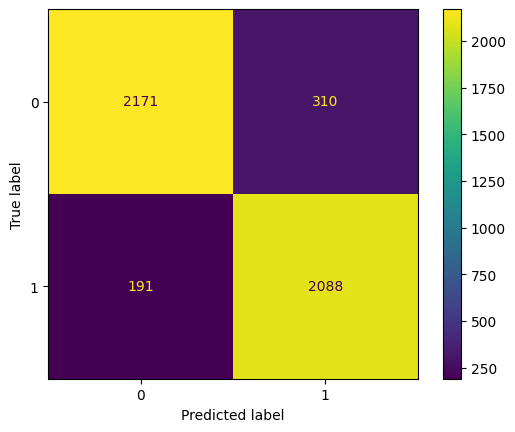

In [69]:
from sklearn import metrics
cm_dm1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_under_balance_dm['label'], y_val_meta), display_labels=meta_under_model.classes_)
cm_dm1.plot()

In [70]:
print(f1_score(valid_under_balance_dm['label'], pred_table['stacking'], average='macro'))

0.8947158877264383


In [71]:
# convert the text data into numeric vectors
corpus = [' '.join(str(word_id) for word_id in document) for document in test['text']]

# learn the token dictionary and return document-term matrix
test_svm_dm1_vec = svm_dm1_vectorizer.transform(corpus)
test_svm_underdm2_vec = svm_underdm2_vectorizer.transform(corpus)
test_svm_dm_under_balance_vec = svm_dm_under_balance_vectorizer.transform(corpus)

test_svm_dm1_X = test_svm_dm1_vec.toarray()
test_svm_underdm2_X = test_svm_underdm2_vec.toarray()
test_svm_dm_under_balance_X = test_svm_dm_under_balance_vec.toarray()

print(test_svm_dm1_X.shape, test_svm_underdm2_X.shape, test_svm_dm_under_balance_X.shape)

(1000, 4900) (1000, 4904) (1000, 4984)


In [72]:
ptest_svm_dm1 = svm_dm1.predict(test_svm_dm1_X)
ptest_svm_underdm2 = svm_underdm2.predict(test_svm_underdm2_X)
ptest_svm_dm_under_balance = svm_dm_under_balance.predict(test_svm_dm_under_balance_X)

In [73]:
X_test_meta = np.column_stack((ptest_svm_dm1,ptest_svm_underdm2,ptest_svm_dm_under_balance))

y_test_meta = meta_under_model.predict(X_test_meta)

In [74]:
df = pd.DataFrame({'id': range(len(y_test_meta)), 'class': y_test_meta})
df.to_csv('data/output_test_svm_meta_under_modele.csv', index=False)

In [75]:
dump(meta_under_model, 'C:/Users/dell/Desktop/svm_meta_under_model_stacking.joblib')
# dump(vectorizer, 'svm_models/svm_dm_merge_vectorizer.joblib')

['C:/Users/dell/Desktop/svm_meta_under_model_stacking.joblib']